In [120]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

dataframe = genfromtxt('train.csv', delimiter=',', skip_header=True)


In [121]:
y, X = dataframe[:,0], dataframe[:, 1:]
y = y.reshape([-1,1])

In [124]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

In [134]:
X_test.shape
y.shape

(64, 1)

In [135]:
import tensorflow as tf

input_ = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1]))
labels = tf.placeholder(dtype=tf.int32, shape=(None, 1))


weight_input_hidden = tf.Variable(tf.random_normal(shape=(int(input_.shape[1]), 64), mean=0.0, stddev=0.01, dtype=tf.float32))
bias_input_hidden = tf.Variable(tf.zeros(weight_input_hidden.shape[1]))


weight_hidden1_hidden2 = tf.Variable(tf.random_normal(shape=(int(weight_input_hidden.shape[1]), 64), mean=0.0, stddev=0.01, dtype=tf.float32))
bias_hidden1_hidden2 = tf.Variable(tf.zeros(weight_hidden1_hidden2.shape[1]))

weight_hidden2_hidden3 = tf.Variable(tf.random_normal(shape=(int(weight_hidden1_hidden2.shape[1]), 64), mean=0.0, stddev=0.01, dtype=tf.float32))
bias_hidden2_hidden3 = tf.Variable(tf.zeros(weight_hidden2_hidden3.shape[1]))

weight_hidden3_hidden4 = tf.Variable(tf.random_normal(shape=(int(weight_hidden2_hidden3.shape[1]), 64), mean=0.0, stddev=0.01, dtype=tf.float32))
bias_hidden3_hidden4 = tf.Variable(tf.zeros(weight_hidden3_hidden4.shape[1]))

weight_hidden_output = tf.Variable(tf.random_normal(shape=(64, 10), mean=0.0, stddev=0.01, dtype=tf.float32))
bias_hidden_output = tf.Variable(tf.zeros(weight_hidden_output.shape[1]))

learning_rate_var = tf.Variable(initial_value=0.001, dtype=tf.float32)

print(input_)
print(labels)
print(weight_input_hidden)
print(bias_input_hidden)
print(weight_hidden1_hidden2)
print(bias_hidden1_hidden2)
print(weight_hidden2_hidden3)
print(bias_hidden2_hidden3)
print(weight_hidden3_hidden4)
print(bias_hidden3_hidden4)
print(weight_hidden_output)
print(bias_hidden_output)

weight_dict = {'layer0': weight_input_hidden, 
               'layer1': weight_hidden1_hidden2, 
               'layer2': weight_hidden2_hidden3,
               'layer3': weight_hidden3_hidden4,
               'layer4': weight_hidden_output}
bias_dict = {'layer0': bias_input_hidden, 
             'layer1': bias_hidden1_hidden2, 
             'layer2': bias_hidden2_hidden3,
             'layer3': bias_hidden3_hidden4,
             'layer4': bias_hidden_output}

Tensor("Placeholder_30:0", shape=(?, 784), dtype=float32)
Tensor("Placeholder_31:0", shape=(?, 1), dtype=int32)
<tf.Variable 'Variable_126:0' shape=(784, 64) dtype=float32_ref>
<tf.Variable 'Variable_127:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'Variable_128:0' shape=(64, 64) dtype=float32_ref>
<tf.Variable 'Variable_129:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'Variable_130:0' shape=(64, 64) dtype=float32_ref>
<tf.Variable 'Variable_131:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'Variable_132:0' shape=(64, 64) dtype=float32_ref>
<tf.Variable 'Variable_133:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'Variable_134:0' shape=(64, 10) dtype=float32_ref>
<tf.Variable 'Variable_135:0' shape=(10,) dtype=float32_ref>


In [136]:
def nn():
    hidden_input = tf.add(tf.matmul(input_, weight_dict['layer0']), bias_dict['layer0'])
    hidden_output = tf.nn.relu(hidden_input)
    hidden_output1 = hidden_output
    
    hidden_input = tf.add(tf.matmul(hidden_output, weight_dict['layer1']), bias_dict['layer1'])
    hidden_output = tf.nn.relu(hidden_input)
    hidden_output2 = hidden_output
    
    hidden_input = tf.add(tf.matmul(hidden_output, weight_dict['layer2']), bias_dict['layer2'])
    hidden_output = tf.nn.relu(hidden_input)
    hidden_output3 = hidden_output
    
    # Find average of hidden1_hidden2 and hidden3_hidden4
    avg_output1 = tf.div(tf.add(hidden_output1, hidden_output3), 2)
    
    hidden_input = tf.add(tf.matmul(avg_output1, weight_dict['layer3']), bias_dict['layer3'])
    hidden_output = tf.nn.relu(hidden_input)
    hidden_output4 = hidden_output
    
    avg_output2 = tf.div(tf.add(hidden_output2, hidden_output4), 2)
    
    output = tf.add(tf.matmul(avg_output2, weight_dict['layer4']), bias_dict['layer4'])
    
    
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=tf.one_hot(labels,depth=10)))
    
    # Apply an optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_var).minimize(cost)
    
    return cost, optimizer, output

In [137]:
def get_next_batch(batch_size, X, y):
    for i in range(int(y.shape[0]/batch_size)-1):
        yield X[i: i+batch_size, :] , y[i: i+batch_size]

In [138]:
cost, optimizer, output = nn()

In [143]:
from sklearn.metrics import accuracy_score

# Initialize tensorflow session
init = tf.global_variables_initializer()

epochs = 1000
batch_size = 64
num_batches = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)

train_accuracy = []
val_accuracy = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    #plt.ion()
    # Training cycle
    for epoch in range(epochs):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all batches
        for x,y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, feed_dict={input_:x, labels:y})
            
        c = sess.run(cost, feed_dict={input_: x, labels: y})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        
        # Find train accuracy
        y_predicted_train_fold = np.argmax(output.eval(feed_dict={input_: X_train_fold, labels: y_train_fold}), 1)
        current_train_acc = accuracy_score(y_true=y_train_fold, y_pred=y_predicted_train_fold)
        
        train_accuracy.append(current_train_acc)
        
        print("Train Accuracy:", current_train_acc)
        
        # Find the validation accuracy
        y_predicted_val_fold = np.argmax(output.eval(feed_dict={input_: X_val_fold, labels: y_val_fold}), 1)
        current_val_acc = accuracy_score(y_true=y_val_fold, y_pred=y_predicted_val_fold)
        
        val_accuracy.append(current_val_acc)
        
        print("Validation Accuracy:", current_val_acc)
        print()
        
        #plt.plot(train_accuracy, 'b-', val_accuracy, 'r-')
        #plt.show()
    
    print("Optimization Finished!")
    
    
    # Find test accuracy
    y_predicted_test = np.argmax(output.eval(feed_dict={input_: X_test, labels: y_test}), 1)
    print("Test Accuracy:", accuracy_score(y_true=y_test, y_pred=y_predicted_test))

Epoch: 0001 cost= 0.112787060
Train Accuracy: 0.812449508908
Validation Accuracy: 0.802721088435

Epoch: 0002 cost= 0.118081033
Train Accuracy: 0.823376844254
Validation Accuracy: 0.82380952381

Epoch: 0003 cost= 0.018098311
Train Accuracy: 0.847910200264
Validation Accuracy: 0.85119047619

Epoch: 0004 cost= 0.026739411
Train Accuracy: 0.843403205919
Validation Accuracy: 0.836904761905

Epoch: 0005 cost= 0.008351916
Train Accuracy: 0.848930651813
Validation Accuracy: 0.857993197279

Epoch: 0006 cost= 0.013755962
Train Accuracy: 0.876270249585
Validation Accuracy: 0.878741496599

Epoch: 0007 cost= 0.005262583
Train Accuracy: 0.879586717122
Validation Accuracy: 0.875

Epoch: 0008 cost= 0.087980077
Train Accuracy: 0.863344529955
Validation Accuracy: 0.856292517007

Epoch: 0009 cost= 0.151381791
Train Accuracy: 0.886687359156
Validation Accuracy: 0.880612244898

Epoch: 0010 cost= 0.011138800
Train Accuracy: 0.878863897275
Validation Accuracy: 0.87619047619

Epoch: 0011 cost= 0.010991734
Tr

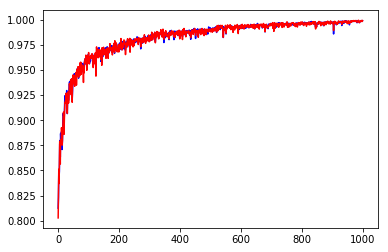

In [144]:
plt.plot(train_accuracy, 'b-', val_accuracy, 'r-')
plt.show()

In [145]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=y_predicted_test)

array([[1228,    0,    6,    0,    1,    4,   10,    2,    8,    4],
       [   0, 1397,    2,    1,    0,    1,    1,    2,    5,    1],
       [   1,    0, 1194,    7,    4,    0,    5,    7,    7,    1],
       [   3,    5,   13, 1261,    0,   15,    1,    7,    6,    6],
       [   1,    4,    5,    0, 1147,    0,    3,    3,    2,   19],
       [   3,    3,    2,    6,    2, 1100,    9,    1,    6,    3],
       [   4,    0,    5,    0,    5,    5, 1206,    0,    2,    0],
       [   1,    1,    9,    2,    2,    3,    0, 1302,    4,    8],
       [   2,   14,    3,    4,    1,    9,    8,    2, 1186,    6],
       [   2,    5,    1,   14,   19,    8,    0,   15,    7, 1201]])

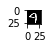

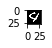

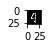

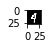

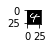

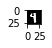

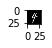

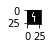

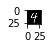

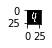

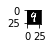

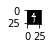

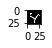

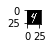

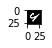

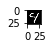

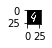

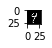

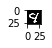

In [147]:
indices = np.where(np.logical_and(y_predicted_test == 9, y_test.squeeze() == 4))[0]
for i in indices:
    plt.figure(figsize=(0.25,0.25))
    plt.imshow(X_test[i].reshape([28,28]),cmap='gray')
    plt.show()